In [1]:
%matplotlib inline
import os
import csv
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Flatten, Dense, Convolution2D, Lambda, Cropping2D, Dropout

print('done')

Using TensorFlow backend.


done


In [2]:
# FUNCTIONAL DEFINITIONS
def loadImage(name):
    if not os.path.isfile(name):
        raise ValueError('File "{}" as {} Does not exist!'.format(name))
    return cv2.cvtColor(cv2.imread(name),cv2.COLOR_BGR2RGB)
    

def generator(samples, batch_size=32, use_side_images = False, steer_correction = 0.2, basepath = 'data/IMG/'):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            for batch_sample in batch_samples:
                name = basepath+batch_sample[0].split('/')[-1]
                # Load & Append image to list:
                images.append(loadImage(name))
                
                steering_center = float(batch_sample[3])
                angles.append(steering_center)
                # if using with side images:
                if use_side_images:
                    # create adjusted steering measurements for the side camera images
                    steering_left = steering_center + steer_correction                    
                    
                    name = basepath+batch_sample[1].split('/')[-1]
                    images.append(loadImage(name))
                    angles.append(steering_left)
                    
                    steering_right = steering_center - steer_correction
                    name = basepath+batch_sample[2].split('/')[-1]
                    images.append(loadImage(name))
                    angles.append(steering_right)
                    pass

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

print('done')

done


In [14]:
# Data Loading
samples = []
# with open('data/driving_log.csv') as csvfile:
# find all .csv files in directory and load each one:
folder = '/home/en/Desktop/Training/'
basepath = folder + 'IMG/'
files = 0
for file in os.listdir(folder):
    if file.endswith(".csv"):
        with open(folder + file) as csvfile:
            files +=1
            reader = csv.reader(csvfile)
            cc = 0
            for line in reader:
                if (cc!= 0):
                    samples.append(line)
                cc+=1

# Partition Data
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

# Print out some data:
print('Total files read: {}'.format(files))
print('Total Data points: {}'.format(len(samples)))
print('Training Samples: {}\nValidation Samples: {}'.format(len(train_samples),len(validation_samples)))

# VARIABLE SETUP:
batch_size = 32
epochs = 3

print('done')

Total files read: 2
Total Data points: 7478
Training Samples: 5982
Validation Samples: 1496
done


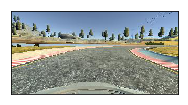

(160, 320, 3)


In [15]:
# test input image from generator:
test_generator = generator(train_samples, batch_size=1, basepath = basepath)
[X_train, y_train] = next(test_generator)

# plot to show image grabbed from generator:
fig = plt.figure(figsize = (3, 3))
axis = fig.add_subplot(1, 1, 1, xticks=[], yticks=[])
axis.imshow(X_train[0])
plt.show()

input_shape = X_train[0].shape
print(input_shape)

In [16]:
input_shape = (160,320,3)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=batch_size, use_side_images = True,  basepath = basepath)
validation_generator = generator(validation_samples, batch_size=batch_size, use_side_images = True,  basepath = basepath)

print(len(train_samples))
print(len(validation_samples))

ch, row, col = 3, 80, 320  # Trimmed image format

model = Sequential()
# Preprocess incoming data, centered around zero with small standard deviation 
model.add(Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape))
# cropping:
model.add(Cropping2D(cropping=((70,25),(0,0))))
# NVidia architecture:
model.add(Convolution2D(24,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Convolution2D(64,3,3,activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(0.7))
model.add(Dense(50))
model.add(Dropout(0.85))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator,
                    samples_per_epoch = 3*len(train_samples),
                    validation_data =validation_generator, 
                    nb_val_samples =len(validation_samples),
                    nb_epoch=5,
                    verbose = 1)

model.save('model.h5')
print('Model Saved!')

5982
1496
Epoch 1/5
17946/17946 [==============================] - 15s - loss: 0.0287 - val_loss: 0.0190
Epoch 2/5
17946/17946 [==============================] - 13s - loss: 0.0219 - val_loss: 0.0178
Epoch 3/5
17946/17946 [==============================] - 12s - loss: 0.0202 - val_loss: 0.0172
Epoch 4/5
17946/17946 [==============================] - 12s - loss: 0.0187 - val_loss: 0.0146
Epoch 5/5
17946/17946 [==============================] - 12s - loss: 0.0173 - val_loss: 0.0144
Model Saved!
